- Python Version : 3.11.9

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles

from sklearn.linear_model import LogisticRegression

import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF

random_state = 42

# 데이터 셋 로드

In [27]:
cancer = load_breast_cancer()

print(cancer['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

## target 값 확인

In [28]:
print(cancer['target'].shape, cancer['target_names'])

(569,) ['malignant' 'benign']


In [29]:
count_malignant, count_benign = np.bincount(cancer['target'])
print(f'malignant의 개수 : {count_malignant}, benign의 개수 : {count_benign}')

malignant의 개수 : 212, benign의 개수 : 357


# 데이터 시각화 및 특성 파악

In [30]:
data = cancer['data']
target = cancer['target']

data_malignant = data[target == 0]
data_benign = data[target == 1]

In [31]:
print(data_malignant.shape)
print(data_benign.shape)

(212, 30)
(357, 30)


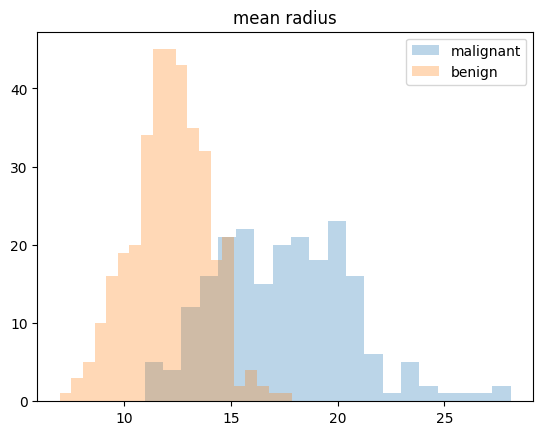

In [32]:
feature_idx = 0

plt.hist(data_malignant[:, feature_idx], bins=20, alpha = 0.3)
plt.hist(data_benign[:, feature_idx], bins=20, alpha = 0.3)

plt.title(cancer['feature_names'][feature_idx])
plt.legend(cancer['target_names'])
plt.show()

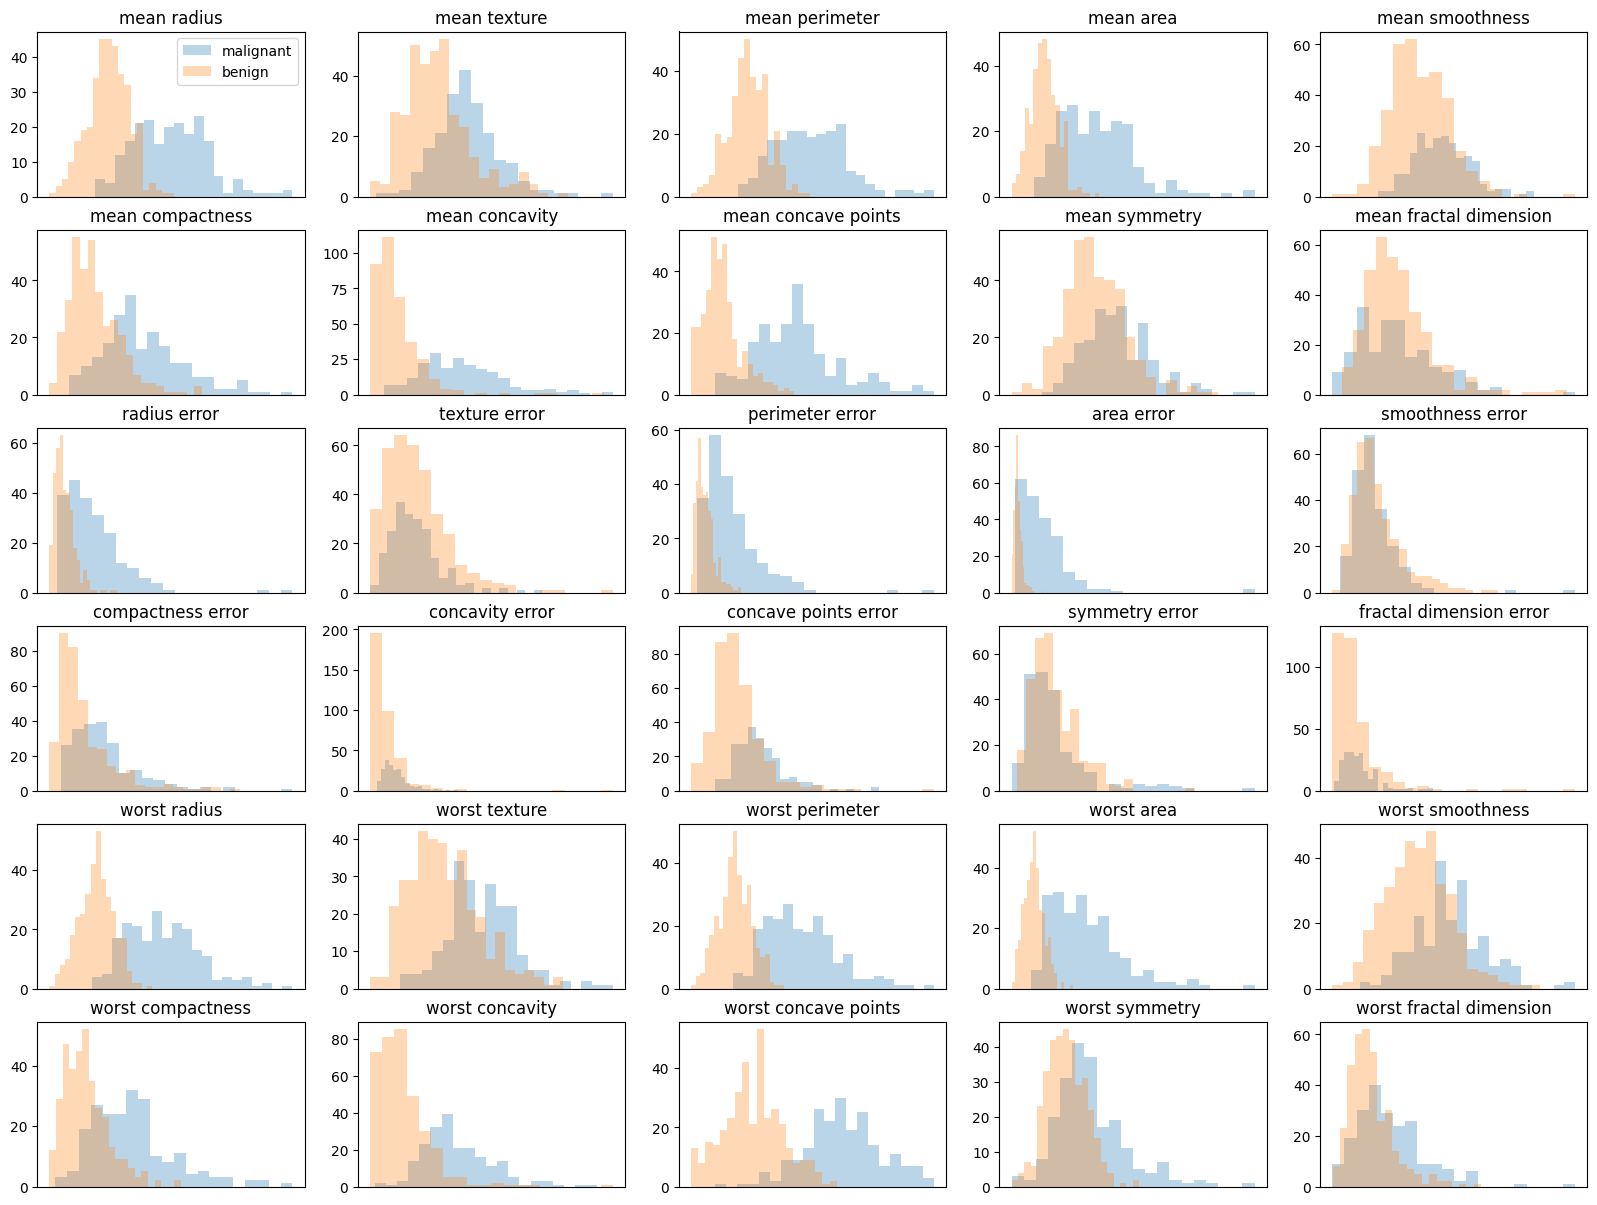

In [33]:
plt.figure(figsize=[20, 15])
for feature_idx in range(30):
    plt.subplot(6, 5, feature_idx + 1)

    plt.hist(data_malignant[:, feature_idx], bins=20, alpha = 0.3)
    plt.hist(data_benign[:, feature_idx], bins=20, alpha = 0.3)

    plt.title(cancer['feature_names'][feature_idx])

    if feature_idx == 0:
        plt.legend(cancer['target_names'])
    
    plt.xticks([])
plt.show()

# 로지스틱 회귀를 통한 이진분류

In [34]:
x_train , x_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=random_state)

model = LogisticRegression(max_iter=5000) # default : max_iter = 100, solver = lbfgs
model.fit(x_train, y_train)

LogisticRegression(max_iter=5000)

In [35]:
score = model.score(x_test, y_test)
score

0.956140350877193

## 결과 분석

- 결과 0 : 악성 -> 암이 있음
- 결과 1 : 양성 -> 암이 없음

> 위험한 상황 : 실제로는 암인 환자를 암이 아니라고 판단하는 경우(False Nagative)

In [36]:
# 기본 임계값은 0.5
probs = model.predict_proba(x_test)[:, 1]

# 1
prediction = model.predict(x_test)

# 2
prediction = (probs > 0.5).astype(int)

FN = ~y_test & prediction
print(f'FN : {FN.sum()} 개')

FN : 4 개


In [37]:
# 임계값을 0.7로 늘리기
prediction = (probs > 0.7).astype(int)

FN = ~y_test & prediction
print(f'FN : {FN.sum()} 개')

FN : 2 개


# 결정 트리를 통한 분류 모델링

In [38]:
dec_tree = DecisionTreeClassifier(max_depth=10, random_state=random_state)
dec_tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [39]:
print('학습 데이터셋 분류 정확도 : ', dec_tree.score(x_train, y_train))
print('평가 데이터셋 분류 정확도 : ', dec_tree.score(x_test, y_test))

학습 데이터셋 분류 정확도 :  1.0
평가 데이터셋 분류 정확도 :  0.9473684210526315


In [42]:
import os
os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin"

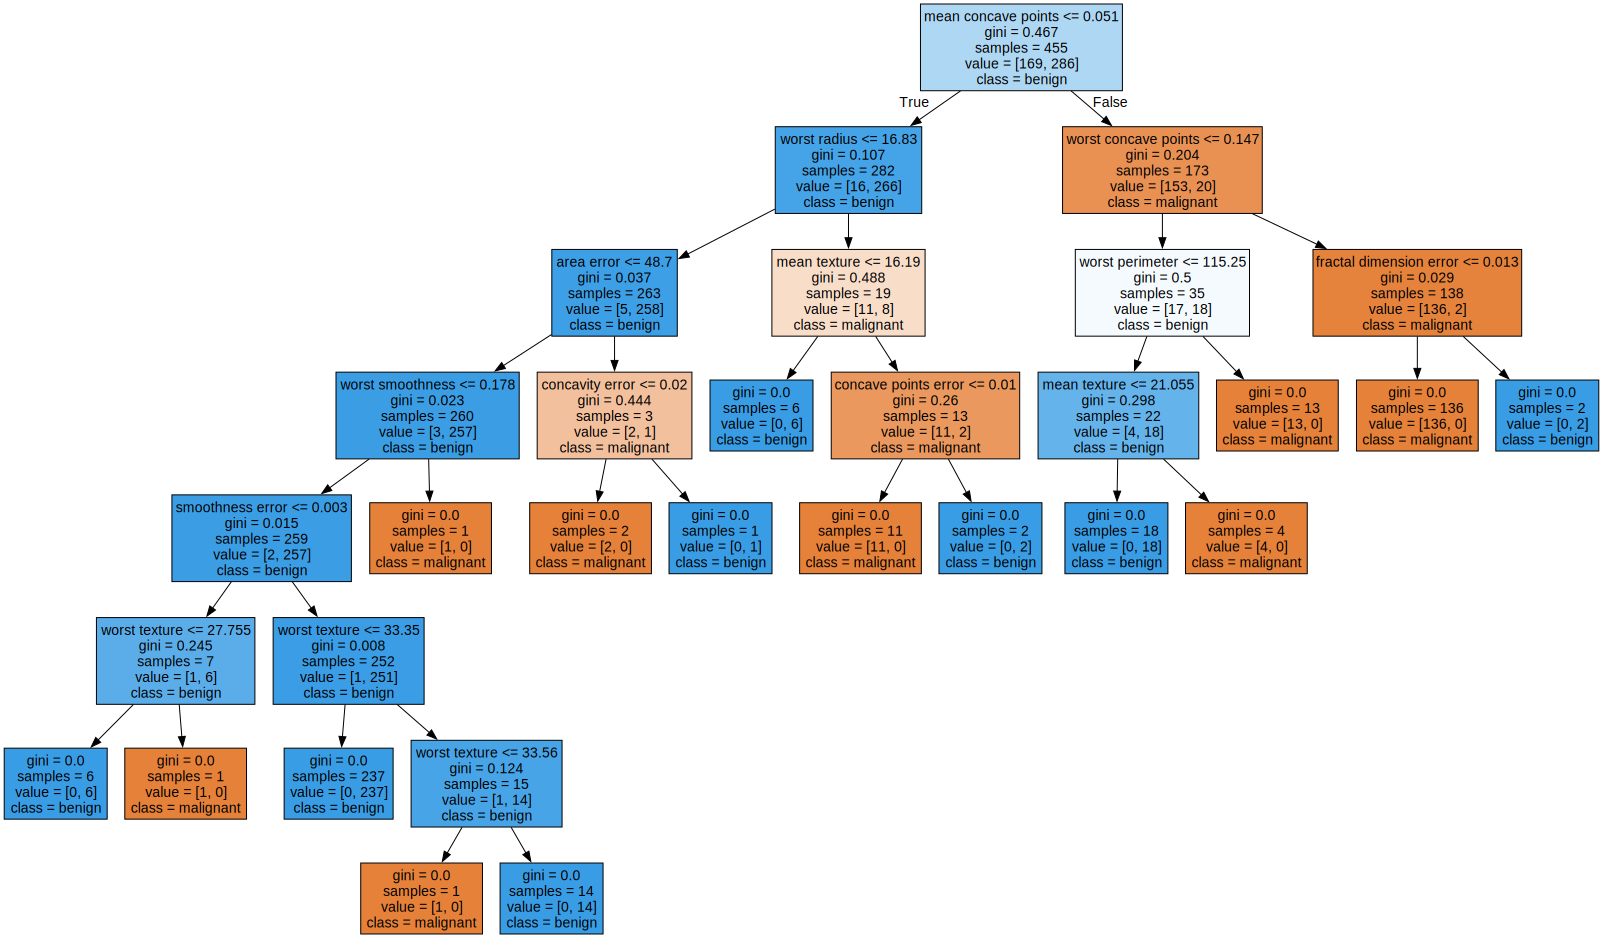

In [43]:
export_graphviz(dec_tree, out_file="tree.dot", class_names=cancer["target_names"],
                feature_names=cancer['feature_names'], impurity=True, filled=True)

with open('tree.dot', 'r') as f:
    dot_graph = f.read()

display(graphviz.Source(dot_graph))

## Feature Importance

In [44]:
print("Feature Importance")
print(dec_tree.feature_importances_)

Feature Importance
[0.         0.05847766 0.         0.         0.         0.
 0.         0.69141955 0.         0.         0.         0.
 0.         0.01198257 0.00123678 0.         0.00627578 0.01593081
 0.         0.01855447 0.05229927 0.01744516 0.05149396 0.
 0.00923319 0.         0.         0.06565079 0.         0.        ]


(-1.0, 30.0)

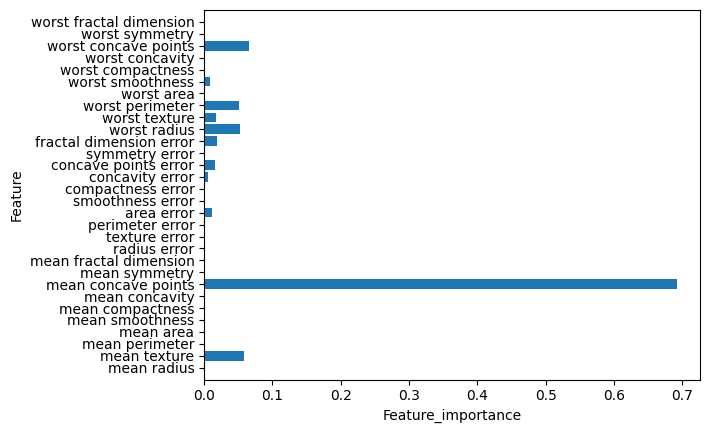

In [46]:
n_features = data.shape[1]
plt.barh(np.arange(n_features), dec_tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), cancer['feature_names'])
plt.xlabel("Feature_importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)

feature importance :  0.06565079001137543


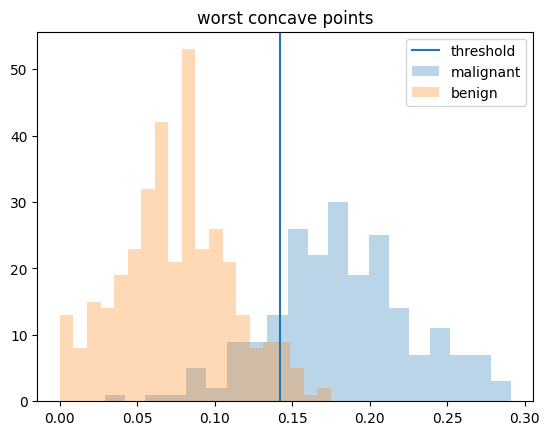

In [48]:
feature_name = "worst concave points"
feature_threshold = 0.142

list_feature_names = cancer["feature_names"].tolist()
feature_idx = list_feature_names.index(feature_name)
print("feature importance : ", dec_tree.feature_importances_[feature_idx])

plt.hist(data_malignant[:, feature_idx], bins=20, alpha=0.3)
plt.hist(data_benign[:, feature_idx], bins=20, alpha=0.3)

plt.axvline(feature_threshold)
plt.title(cancer['feature_names'][feature_idx])
plt.legend(['threshold'] + list(cancer['target_names']))
plt.show()